In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gvclsu/water-segmentation-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/water-segmentation-dataset


In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize


2026-02-05 18:42:46.220767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770316966.407063      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770316966.461957      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770316966.922442      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770316966.922477      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770316966.922480      24 computation_placer.cc:177] computation placer alr

In [4]:
import pandas as pd
BASE_PATH = "/kaggle/input/water-segmentation-dataset/water_v1/water_v1"
print(os.listdir(BASE_PATH))

['val.txt', 'Annotations', 'train.txt', 'JPEGImages']


In [5]:
from glob import glob
import os

IMAGE_PATH = os.path.join(BASE_PATH, "JPEGImages")

image_paths = (
    glob(os.path.join(IMAGE_PATH, "**", "*.jpg"), recursive=True) +
    glob(os.path.join(IMAGE_PATH, "**", "*.png"), recursive=True)
)

image_paths = sorted(image_paths)

print("Total images found:", len(image_paths))
print(image_paths[:5])


Total images found: 10704
['/kaggle/input/water-segmentation-dataset/water_v1/water_v1/JPEGImages/ADE20K/ADE_train_00000004.png', '/kaggle/input/water-segmentation-dataset/water_v1/water_v1/JPEGImages/ADE20K/ADE_train_00000191.png', '/kaggle/input/water-segmentation-dataset/water_v1/water_v1/JPEGImages/ADE20K/ADE_train_00000407.png', '/kaggle/input/water-segmentation-dataset/water_v1/water_v1/JPEGImages/ADE20K/ADE_train_00000555.png', '/kaggle/input/water-segmentation-dataset/water_v1/water_v1/JPEGImages/ADE20K/ADE_train_00000556.png']


In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize
import numpy as np

IMG_SIZE = 256

def load_image(path, mask=False):
    img = load_img(
        path,
        color_mode="grayscale" if mask else "rgb"
    )
    img = img_to_array(img)
    img = resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    return img


In [7]:
from tqdm import tqdm

def load_data(paths):
    images, masks = [], []

    for path in tqdm(paths, desc="Loading"):
        mask_path = (
            path.replace("JPEGImages", "Annotations")
                .replace(".jpg", ".png")
        )

        if not os.path.exists(mask_path):
            continue

        images.append(load_image(path, mask=False))
        masks.append(load_image(mask_path, mask=True))

    return np.array(images), np.array(masks)

In [8]:
image_paths = image_paths[:10704]  # limit for Kaggle

X_all, y_all = load_data(image_paths)

print(X_all.shape)
print(y_all.shape)

Loading:   0%|          | 0/10704 [00:00<?, ?it/s]I0000 00:00:1770316983.488724      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770316983.494883      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Loading: 100%|██████████| 10704/10704 [01:33<00:00, 114.99it/s] 


(2168, 256, 256, 3)
(2168, 256, 256, 1)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)


Train: (1734, 256, 256, 3) (1734, 256, 256, 1)
Val  : (434, 256, 256, 3) (434, 256, 256, 1)


In [10]:
IMG_SIZE = 256
PATCH_SIZE = 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2

EMBED_DIM = 256
NUM_HEADS = 4
NUM_LAYERS = 6

BATCH_SIZE = 8
EPOCHS = 25


In [11]:
class PatchEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size):
        super().__init__()
        self.proj = layers.Conv2D(
            embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="valid"
        )

    def call(self, x):
        x = self.proj(x)
        x = tf.reshape(x, (tf.shape(x)[0], -1, x.shape[-1]))
        return x

In [12]:
def transformer_encoder(x, embed_dim, num_heads):
    # Self Attention
    attn = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim
    )(x, x)

    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    # Feed Forward Network
    ffn = layers.Dense(embed_dim * 4, activation="relu")(x)
    ffn = layers.Dense(embed_dim)(ffn)

    x = layers.Add()([x, ffn])
    x = layers.LayerNormalization()(x)

    return x

In [13]:
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Patch embedding
x = PatchEmbedding(EMBED_DIM, PATCH_SIZE)(inputs)

# Transformer encoder stack
for _ in range(NUM_LAYERS):
    x = transformer_encoder(x, EMBED_DIM, NUM_HEADS)

# Tokens → feature map
x = layers.Reshape(
    (IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE, EMBED_DIM)
)(x)

# Decoder (upsampling)
x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(x)

# Output mask
outputs = layers.Conv2D(1, 1, activation="sigmoid")(x)
model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, None, 256) │    196,864 │ input_layer[0][0] │
│ (PatchEmbedding)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 256) │  1,051,904 │ patch_embedding[… │
│ (MultiHeadAttentio… │                   │            │ patch_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 256) │          0 │ patch_embedding[… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 256) │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │    263,168 │ layer_normalizat… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 256) │    262,400 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 256) │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 256) │        512 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 256) │  1,051,904 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 256) │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 256) │        512 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None,      │    263,168 │ layer_normalizat… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None, 256) │    262,400 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, None, 256) │          0 │ layer_normalizat… │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 256) │        512 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 256) │  1,051,904 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 10,059,777 (38.38 MB)

 Trainable params: 10,059,777 (38.38 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )

In [15]:
model.compile(
    optimizer="adam",
    loss=dice_loss,
    metrics=["accuracy"]
)

In [16]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/25


I0000 00:00:1770317097.285083      67 service.cc:152] XLA service 0x7e71f0053110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770317097.285142      67 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770317097.285149      67 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1770317100.141157      67 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-05 18:45:02.278156: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-05 18:45:02.433515: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-05 18:45:03.206460: E external/local_xl

  1/217 ━━━━━━━━━━━━━━━━━━━━ 1:30:16 25s/step - accuracy: 0.6997 - loss: 0.6488

I0000 00:00:1770317109.823763      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


216/217 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2783 - loss: 0.6326

2026-02-05 18:45:28.310939: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-05 18:45:28.465784: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-05 18:45:29.248261: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-05 18:45:29.541179: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


217/217 ━━━━━━━━━━━━━━━━━━━━ 57s 149ms/step - accuracy: 0.2784 - loss: 0.6324 - val_accuracy: 0.3047 - val_loss: 0.5933
Epoch 2/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.3048 - loss: 0.5916 - val_accuracy: 0.3047 - val_loss: 0.5933
Epoch 3/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.2962 - loss: 0.6040 - val_accuracy: 0.3048 - val_loss: 0.5933
Epoch 4/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.2943 - loss: 0.6062 - val_accuracy: 0.3047 - val_loss: 0.5933
Epoch 5/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.3005 - loss: 0.5969 - val_accuracy: 0.3047 - val_loss: 0.5933
Epoch 6/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.2995 - loss: 0.5989 - val_accuracy: 0.3047 - val_loss: 0.5933
Epoch 7/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.2955 - loss: 0.6048 - val_accuracy: 0.3047 - val_loss: 0.5933
Epoch 8/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 18s 85ms/step - accuracy: 0.2966 - loss: 0.6027 - val_accura

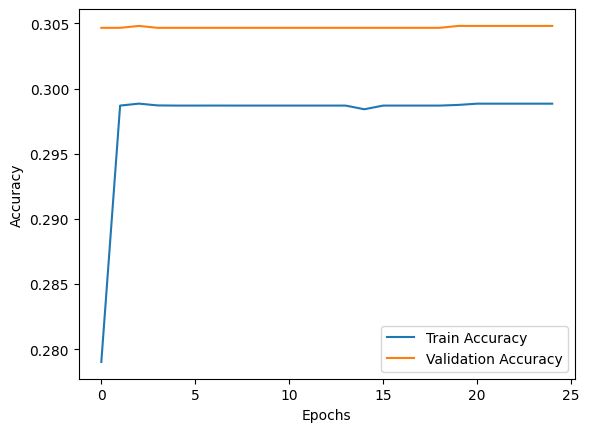

In [17]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


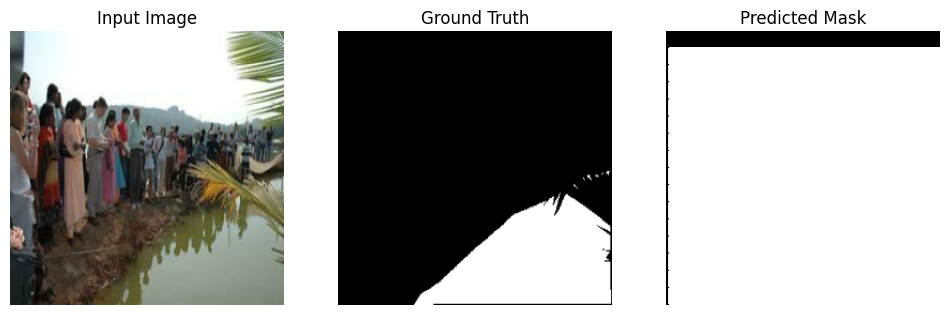

In [18]:
import numpy as np

idx = np.random.randint(0, len(X_val))

pred = model.predict(X_val[idx:idx+1])[0]

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(X_val[idx])
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(y_val[idx].squeeze(), cmap="gray")
plt.title("Ground Truth")
plt.axis("off")


plt.subplot(1,3,3)
plt.imshow(pred.squeeze() > 0.5, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")
plt.show()